<center> 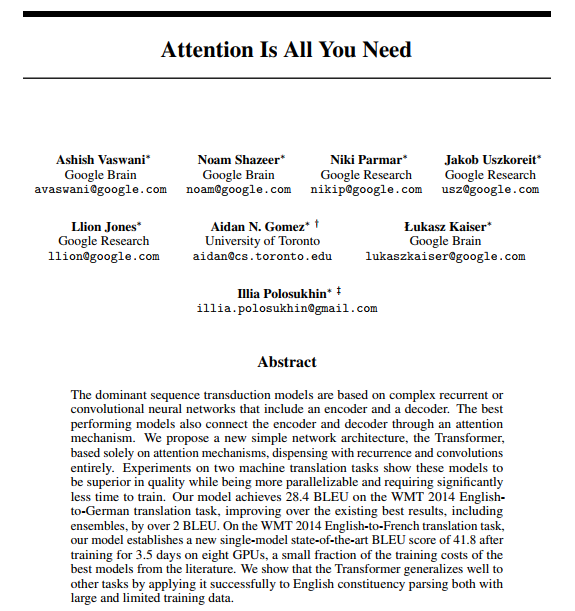

## Introduction

In 2017, researchers from Google published a paper titled [**Attention Is All You Need**](https://arxiv.org/pdf/1706.03762), introducing a novel architecture called the **Transformer** in the context of machine translation tasks. This architecture has significantly influenced AI research and inspired many other applications.

The **Transformer** is at the heart of modern **Large Language Models** (LLMs), the most famous of which is [**ChatGPT**](https://chat.openai.com/) from [**OpenAI**](https://openai.com/). **ChatGPT** is based on the **GPT** architecture, which stands for **Generative Pre-trained Transformer** and serves as an assistant chatbot. Another notable application of the **Transformer** architecture is **BERT**, described in the [**BERT: Pre-training of Deep Bidirectional Transformers for Language Understanding**](https://arxiv.org/pdf/1810.04805) paper. The **BERT** model is used in many tasks like sentiment analysis, question answering (Q&A), and more.

In this tutorial, we will delve deep into the [**Attention Is All You Need**](https://arxiv.org/pdf/1706.03762) paper, exploring the **Transformer** architecture in depth, from theory to code.

<figure markdown="span">
    <center>
  <img src="https://www.researchgate.net/publication/323904682/figure/fig1/AS:606458626465792@1521602412057/The-Transformer-model-architecture.png" width="320" />  
  <figcaption> <b>Tranformer Architecture</figcaption>
</figure>

## 1. What's Motivation behind Transformers ?

**Recurrent Neural Networks (RNNs)** were once the state-of-the-art for sequence-to-sequence modeling. They are used for handling sequence data such as language modeling, speech recognition, machine translation, and more.

<figure markdown="span">
    <center>
  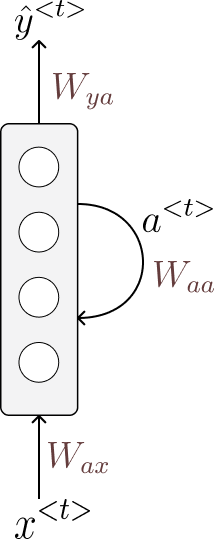  
  <figcaption> <b>Recurrent Neural Networks Architecture</figcaption>
</figure>

**RNNs** are quite effective for handling small sequences. However, they lose efficiency when dealing with large sequences. To address this, **Long Short-Term Memory (LSTM)** and **Gated Recurrent Unit (GRU)**, which are variants of **RNNs**, were introduced to tackle the vanishing gradients issue that arises with longer sequences. Despite these advancements, all RNN architectures still suffer from several issues:

- **RNNs are slow**: Due to their sequential nature, RNNs process inputs one at a time to generate the output. For example, to process the third token in a sequence, we must first process the first and second tokens. This sequential dependency makes both training and inference slow.

- **Gradient issues**: **Vanishing Gradient** and **Exploding Gradient** are significant problems with RNNs. Although **LSTMs** and **GRUs** were designed to mitigate these issues, they remain unavoidable when dealing with long contexts and sequences.

- **Context Representations**: The intermediate activation vectors passed from the previous hidden state $h_{t-1}$ to the current hidden state $h_t$ are meant to carry information from previous tokens. However, it is uncertain whether they accurately represent the context, especially with long dependencies where information tends to be lost.


In the next sections, we will explore how **Transformers** address these issues using a clever trick called the **Attention Mechanism**.

## 2. Understanding Tokenization in Language Modeling

First of all, before we dive into understanding what tokenization is, I want to mention that **Andrej Karpathy** created a great video on this topic.

You can find it here [https://www.youtube.com/watch?v=zduSFxRajkE](https://www.youtube.com/watch?v=zduSFxRajkE).

<figure markdown="span">
    <center>
  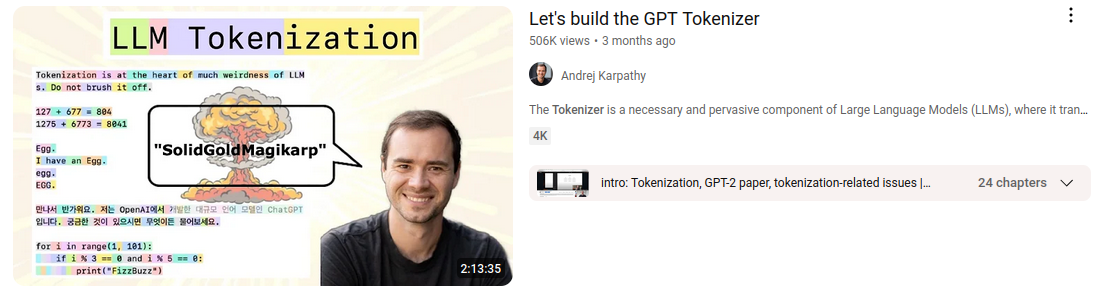  
  <figcaption> <b>Let's build the GPT Tokenizer</figcaption>
</figure>

### What's Tokenization ?

In simple terms, **Tokenization** is the process of breaking sequences into smaller **tokens**. These tokens can vary in size, ranging from single letters to sub-words, words, or even multiple words. Each token is then assigned an integer that represents its unique identifier, or `id`.

The **Tokenization** stage is very critical before plugging text sequences naively into the language models; without it, they won't work.

Actually, you can test the tokenization online by visiting the following website [tiktokenizer](https://tiktokenizer.vercel.app/?model=o200k_base). After entering some text, you can visually see that the sequence is broken into tokens on the right, with different colors.

<figure markdown="span">
    <center>
  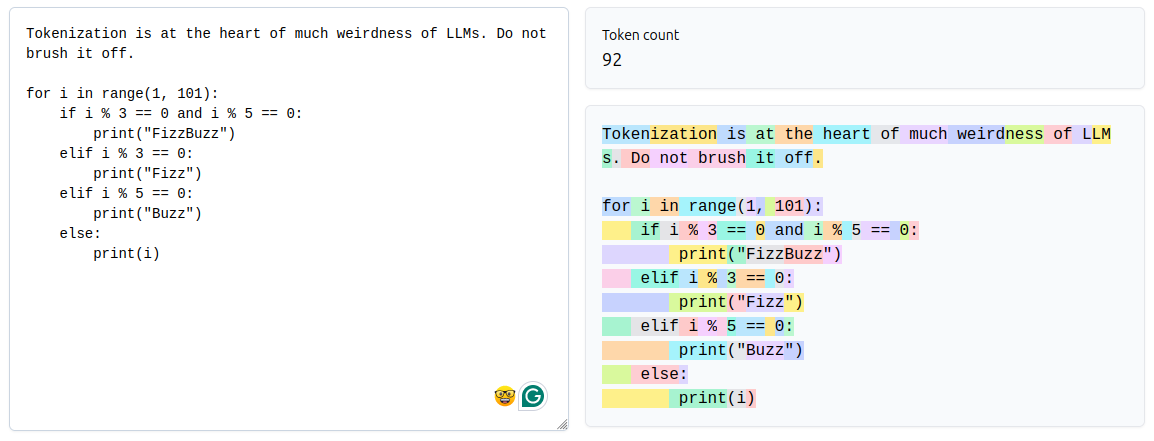
  <figcaption> <b>Tiktoken Vercel App</figcaption>
</figure>

### Why Tokenization is important?

<div class="admonition question">
    <p class="admonition-title">Question</p>
    <p>A very good question that can be asked at this moment is, <b>why don't we just consider words as tokens, separated by white space?</b>
    </p>
</div

It's very convenient and logical to consider why complicate things by breaking words into sub-words, etc.

In simple terms, if we consider tokens as just words separated by white space, we'll actually encounter a couple of issues:

- Firstly, the text sequences we work with are not always written in high-quality format. For example, if the sequence contains something like `Attention isallyou need`, we would consider `isallyou` as one word, but it's actually three different words. Therefore, we need a clever way to tokenize the sequence.

- Secondly, tokenization determines the vocabulary, which consists of unique tokens. If we consider tokens as just words, we end up with a very large vocabulary size, potentially in the order of **hundreds of thousands** or even **millions**. This can be challenging when dealing with language modeling. However, if we consider tokens as just characters, we end up with a vocabulary size of around a hundred. This is not sufficient for effective language modeling. Therefore, the solution is to find a trade-off between the two.

In the tutorial **Let's build the GPT Tokenizer**, **Andrej Karpathy** raises some issues with **LLMs** due to bad **Tokenization**, here are some of them:

- Why can't LLM spell words?
- Why can't LLM perform super simple string processing tasks like reversing a string?
- Why is LLM worse at non-English languages (e.g. Japanese)?
- Why is LLM bad at simple arithmetic?
- Why did GPT-2 have more than necessary trouble coding in Python?

### Tokenization in code

In fact, there are many tokenizers available, and each LLM comes with its own tokenizer. For OpenAI, it uses [tiktoken](https://github.com/openai/tiktoken) for their GPT LLMs, which is based on the [Byte Pair Encoding](https://en.wikipedia.org/wiki/Byte_pair_encoding) algorithm. Google uses [SentencePiece](https://github.com/google/sentencepiece), an unsupervised text tokenizer.

In this section, we're going to use a toy examples with **tiktoken**.

First, let's install the `tiktoken` library.

In [4]:
!pip install tiktoken

Defaulting to user installation because normal site-packages is not writeable
  Obtaining dependency information for tiktoken from https://files.pythonhosted.org/packages/61/b4/b80d1fe33015e782074e96bbbf4108ccd283b8deea86fb43c15d18b7c351/tiktoken-0.7.0-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 2.2 MB/s eta 0:00:00m eta 0:00:010:00:010m


Next, import the library and load the tokenizer for `gpt2`.

In [5]:
import tiktoken

encoder = tiktoken.get_encoding("gpt2")

In [6]:
encoder

<Encoding 'gpt2'>

Now, let's use the `gpt2` tokenizer to encode the text `hello everyone` and then decode it.

In [22]:
code = encoder.encode("hello everyone")
code

[31373, 2506]

In [23]:
[encoder.decode([c]) for c in code]

['hello', ' everyone']